# X Inactivation

I'd like to explore the state of genes on the X chromosome and see to what degree
the iPSCs reactivate their inactive Xs.

In [2]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'x_inactivation')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'x_inactivation')
cpy.makedir(private_outdir)

In [3]:
sns.set_style('whitegrid')

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [6]:
sf = subject_meta[subject_meta.sex == 'F']
meta = sf.merge(rna_meta, left_index=True, right_on='subject_id')
meta = meta.ix[[x for x in snv_p.items if x in meta.index]]

snv_p = snv_p.ix[meta.index]

In [7]:
snv_p = snv_p.ix[meta.index]
locus_p = locus_p.ix[meta.index]

In [8]:
# Filter  and take log.
tpm_f = tpm[meta[meta.sex == 'F'].index]
tpm_f = tpm_f[(tpm_f != 0).sum(axis=1) > 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

## Inactivation for Single Sample

Let's take a look at one sample.

In [9]:
df = locus_p.ix[meta.index[0], :, :].dropna()
x_single = df[gene_info.ix[df.index, 'chrom'] == 'chrX']
notx_single = df[gene_info.ix[df.index, 'chrom'] != 'chrX']

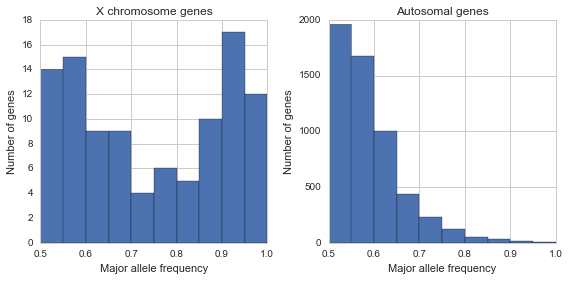

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
x_single.major_allele_freq.hist(ax=ax, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
ax = axs[1]
notx_single.major_allele_freq.hist(ax=ax, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
plt.tight_layout();
#plt.savefig(os.path.join(outdir, 'single_sample_majaf.pdf'))

This figure shows the distribution of gene major allele frequencies for
genes on the X chromosome and for genes on the autosomes. We can see that
autosomal genes often have a MajAF near 50% with few genes near 100%. However,
many X chromosome genes are near 100%. These genes are likely still inactivated.

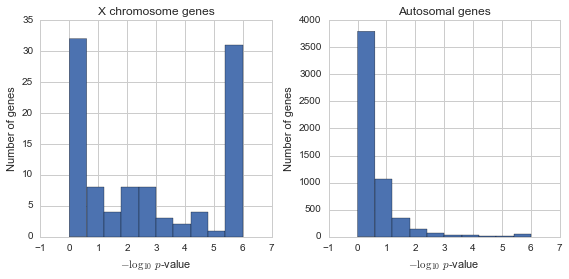

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
(-np.log10(x_single.p_val_ase + x_single.p_val_ase[x_single.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ax = axs[1]
(-np.log10(notx_single.p_val_ase + notx_single.p_val_ase[notx_single.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout();

We can see that the X chromosome is enriched for genes with strong ASE
likely due to incomplete X reactivation.

## Inactivation for All Samples

Let's take a look at all female samples.

In [12]:
t = locus_p.ix[:, :, 'major_allele_freq']
x_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index), :]
notx_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom != 'chrX'].index), :]

In [13]:
sns.set_context('poster')

In [14]:
genes_to_plot = ['XIST', 'TSIX', 'NANOG', 'OCT4', 'SOX2']
t = pd.Series(gene_info.index, index=gene_info.gene_name)
    
exp = log_tpm_n.ix[t].T

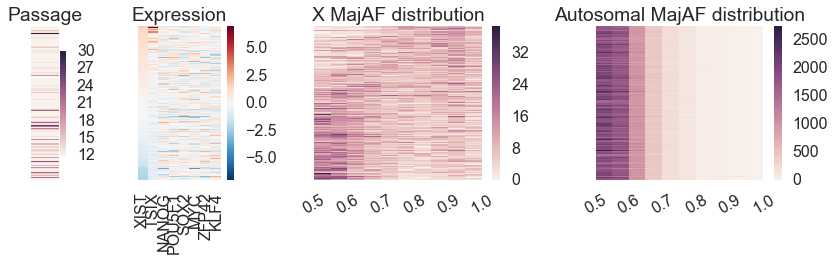

In [15]:
genes_to_plot = ['XIST', 'TSIX', 'NANOG', 'POU5F1', 'SOX2', 'MYC', 'ZFP42', 'KLF4']
t = pd.Series(gene_info.index, index=gene_info.gene_name)
    
exp = log_tpm_n.ix[t[genes_to_plot]].T
exp.columns = genes_to_plot
# exp = log_tpm_n.ix[[gene_info[gene_info.gene_name == 'XIST'].index[0], 
#                     gene_info[gene_info.gene_name == 'TSIX'].index[0]]].T
# exp.columns = ['XIST', 'TSIX']
exp = exp.ix[x_all.items].sort_values(by='XIST', ascending=False)

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[0.5, 1.5, 3, 3])

ax = plt.subplot(gs[0])
sns.heatmap(np.array([meta.ix[exp.index, 'passage'].values]).T, 
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Passage')

ax = plt.subplot(gs[1])
sns.heatmap(exp, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Expression')
#for t in ax.get_xticklabels():
#    t.set_rotation(30)

ax = plt.subplot(gs[2])
r = x_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                       bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
ax.set_title('X MajAF distribution')

ax = plt.subplot(gs[3])
r = notx_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                          bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
ax.set_title('Autosomal MajAF distribution')

gs.tight_layout(fig)
fig.savefig(os.path.join(outdir, 'x_reactivation_heatmap.png'), dpi=600)

These heatmaps are all aligned by row (so the first row across all heatmaps
is the same sample, the second row across all heatmaps is the same sample, etc.).
The heatmaps are ordered by each sample's XIST expression (shown in the second heatmap).
The X MajAF distribution heatmap is the same as the histogram above for one sample
but now we are stacking up the histograms for all samples. We can see that many
samples have genes that are inactive although the amount of inactivation varies
between samples and is highly correlated with XIST.

The X chromosome is clearly enriched for having ASE which is probably due
to incomplete X reactivation.

In [16]:
t = x_all.ix[:, :, 'p_val_ase']
freq = (t < 0.005).sum() / (t.isnull() == False).sum()
print('{:.2f}% of genes per sample have significant ASE on chrX.'.format(freq.mean() * 100))
t = notx_all.ix[:, :, 'p_val_ase']
freq = (t < 0.005).sum() / (t.isnull() == False).sum()
print('{:.2f}% of genes per sample have significant ASE on autosomes.'.format(freq.mean() * 100))

44.24% of genes per sample have significant ASE on chrX.
2.88% of genes per sample have significant ASE on autosomes.


In [17]:
sns.set_context('notebook')

In [18]:
xist_gene_id = gene_info[gene_info.gene_name == 'XIST'].index[0]
tsix_gene_id = gene_info[gene_info.gene_name == 'TSIX'].index[0]

In [19]:
r = stats.spearmanr(meta.passage, log_tpm_n.ix[xist_gene_id, meta.index])
print('Passage and XIST expression are correlated (r={:.2f}) with p={:.3f}.'.format(
    r.correlation, r.pvalue))

Passage and XIST expression are correlated (r=-0.18) with p=0.029.


In [20]:
r = stats.spearmanr(meta.passage, log_tpm_n.ix[tsix_gene_id, meta.index])
print('Passage and TSIX expression are correlated (r={:.2f}) with p={:.3f}.'.format(
    r.correlation, r.pvalue))

Passage and TSIX expression are correlated (r=-0.17) with p=0.044.


In [21]:
percent_ase = ((x_all.ix[:, :, 'p_val_ase'] < 0.005).sum() / 
               (x_all.ix[:, :, 'p_val_ase'].isnull() == False).sum())

In [22]:
r = stats.spearmanr(percent_ase, meta.ix[percent_ase.index, 'passage'])
print('Percent ASE and passage are not correlated (r={:.2f}, p={:.3f}).'.format(
    r.correlation, r.pvalue))

Percent ASE and passage are not correlated (r=-0.07, p=0.432).


In [23]:
r = stats.spearmanr(percent_ase, log_tpm_n.ix[xist_gene_id, percent_ase.index])
print('Percent ASE and XIST expression are correlated (r={:.2f}) with p={:.3e}.'.format(
    r.correlation, r.pvalue))

Percent ASE and XIST expression are correlated (r=0.72) with p=4.020e-25.


In [24]:
r = stats.spearmanr(percent_ase, log_tpm_n.ix[tsix_gene_id, percent_ase.index])
print('Percent ASE and TSIX expression are correlated (r={:.2f}) with p={:.3e}.'.format(
    r.correlation, r.pvalue))

Percent ASE and TSIX expression are correlated (r=0.51) with p=2.279e-11.


### X chromosome gene expression

Are reactivated genes expressed more highly?

In [25]:
t = locus_p.ix[:, :, 'p_val_ase']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
t = t.ix[set(log_tpm_n.index) & set(t.index)]

rows = []
for i in t.index:
    se = t.ix[i]
    se = se[se.isnull() == False]
    a = log_tpm_n.ix[i, se[se <= 0.005].index]
    b = log_tpm_n.ix[i, se[se > 0.005].index]
        
    rows.append([se.shape[0], a.shape[0], b.shape[0], a.mean(), b.mean()])
    
x_exp = pd.DataFrame(rows, columns=['num_samples', 'num_sig', 'num_not_sig', 
                                    'mean_sig_exp', 'mean_not_sig_exp'],
                     index=t.index)
x_exp = x_exp[(x_exp.num_sig >= 5) & (x_exp.num_not_sig >= 5)]

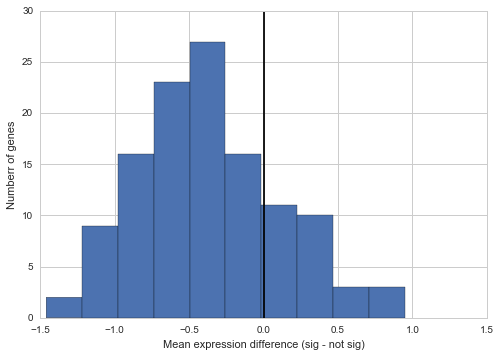

In [26]:
(x_exp.mean_sig_exp - x_exp.mean_not_sig_exp).hist()
plt.ylabel('Numberr of genes')
plt.xlabel('Mean expression difference (sig - not sig)')
xmin, xmax = plt.xlim()
plt.xlim(-max(abs(xmin), abs(xmax)), max(abs(xmin), abs(xmax)))
ymin, ymax = plt.ylim()
plt.vlines(0, ymin, ymax);

The histogram above shows that genes have higher average expression
in samples where the gene does not have significant ASE.

### Reactivation percent

Only some genes show residual inactivation. Are these the same genes across samples?

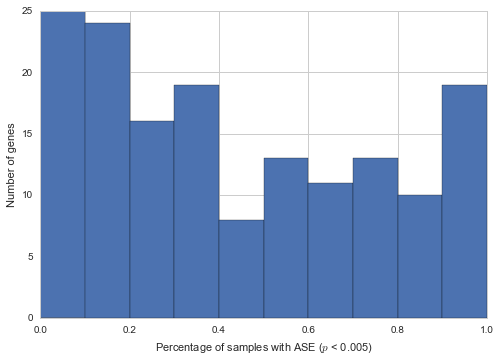

In [27]:
t = locus_p.ix[:, :, 'p_val_ase']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
freq = (t[t.isnull() == False] < 0.005).sum(axis=1) / (t.isnull() == False).sum(axis=1)

freq.hist()
plt.ylabel('Number of genes')
plt.xlabel('Percentage of samples with ASE ($p$ < 0.005)');

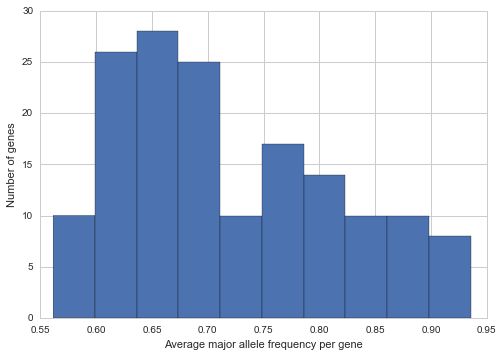

In [28]:
tt = locus_p.ix[:, t.index, 'major_allele_freq']

tt.mean(axis=1).hist()
plt.ylabel('Number of genes')
plt.xlabel('Average major allele frequency per gene');

The above histogram shows what percentage of samples were significant
for ASE. Note that a gene in a sample is
included here only if it was tested by MBASED for ASE. I restricted to
genes that were tested by MBASED in at least 20% of the samples.

## Reactivation across the X chromosome

I'd like to look at how genes are reactivated across the X chromosome.
For instance, is reactivation correlated with replication timing or 
L1 density? I can consider things like

* replication timing 
* distance from centromere or telomere 
* XIST binding motif density (does it have a binding motif?)
* distance from X inactivation center
* L1 density

In [29]:
t = gene_info.ix[x_all.major_axis]
r = ((t.end - t.start) / 2).astype(int)
start = (t.start + r - (((t.end - t.start) / 2 % 1) == 0)).astype(int).astype(str)
end = (t.end - r).astype(int).astype(str)
s = '\n'.join(t.chrom + '\t' + start + '\t' + end + '\t' + 
              pd.Series(t.index, index=t.index)) + '\n'
xgenes_center_bt = pbt.BedTool(s, from_string=True)
xgenes_center_bt = xgenes_center_bt.sort()

### Replication timing

In [30]:
# Replication timing data.
rt = pd.read_table('/publicdata/replication_domain_db_20151103/RD_sm300_2936763_hFibiPS4p72.hg19.txt',
                   low_memory=False, skiprows=15, index_col=0)
rt = rt[rt.Chromosome == 'chrX']
s = '\n'.join(rt.Chromosome + '\t' + rt.Start_Position.astype(str) + 
              '\t' + rt.End_Position.astype(str) + '\t' + rt.Data_Value.astype(str))
rt_bt = pbt.BedTool(s, from_string=True)
rt_bt = rt_bt.sort()

In [31]:
res = xgenes_center_bt.closest(rt_bt, d=True)
df = res.to_dataframe()
rt_by_gene = pd.Series(df.thickEnd.values, index=df.name)

### L1 elements

I downloaded the repeat masker database from the table browser (group: Repeats, 
track: RepeatMasker, output format: all fields from selected table) to the file
`rmsk_db.txt.gz`. I also downloaded the database as a bed file from the table browser
to the file `rmsk.bed`. I put both of these in the output directory.

In [45]:
fn = os.path.join(outdir, 'line_one_elements.tsv')
if not os.path.exists(fn):
    rmsk = os.path.join(outdir, 'rmsk_db.txt.gz')
    repeat_db = pd.read_table(rmsk, low_memory=False)
    line_one_elements = repeat_db[repeat_db.repFamily == 'L1']
    line_one_elements = line_one_elements[line_one_elements.genoName == 'chrX']
    line_one_elements.to_csv(fn, sep='\t')
else:
    line_one_elements = pd.read_table(fn, index_col=0)
    
fn = os.path.join(outdir, 'line_one_elements.bed')
if not os.path.exists(fn):
    repeats = pd.read_table(os.path.join(outdir, 'rmsk.bed'), header=None, low_memory=False)
    repeats = repeats[repeats[0] == 'chrX']
    repeat_db = pd.read_table(rmsk, low_memory=False)
    se = pd.Series(dict(zip(repeat_db.repName, repeat_db.repFamily)))
    r = repeats[repeats[3].apply(lambda x: se[x] == 'L1')]
    s = '\n'.join(['\t'.join(x) for x in r.astype(str).values]) + '\n'
    line_one_bt = pbt.BedTool(s, from_string=True)
    line_one_bt = line_one_bt.sort()
    line_one_bt.saveas(fn)
else:
    line_one_bt = pbt.BedTool(fn)
    
res = xgenes_center_bt.window(line_one_bt, w=100000)
df = res.to_dataframe()
line_one_by_gene = df.name.value_counts()

In [53]:
line_one_bedgraph = os.path.join(outdir, 'line_one.bedGraph')
if not os.path.exists(line_one_bedgraph):
    res = line_one_bt.genome_coverage(g=pbt.genome_registry.hg19, bg=True)
    res.saveas(line_one_bedgraph)
    
line_one_bw = os.path.join(outdir, 'line_one.bw')
if not os.path.exists(line_one_bw):
    !bedGraphToBigWig {line_one_bedgraph} /software/bedtools-2.25.0/genomes/human.hg19.genome {line_one_bw}

In [34]:
line_one_bam = os.path.join(outdir, 'line_one_uniq_sorted.bam')
if not os.path.exists(line_one_bam):
    df = line_one_bt.to_dataframe()
    df.name = df.name + '_' + pd.Series(range(df.shape[0])).astype(str)
    fn = os.path.join(outdir, 'line_one_uniq.bed')
    df.to_csv(fn, header=None, index=None, sep='\t')
    out = os.path.join(outdir, 'line_one_uniq.bam')
    !bedToBam -i {fn} -g /frazer01/software/bedtools-2.25.0/genomes/human.hg19.genome > {out}
    !sambamba sort -o {line_one_bam} {out}
    !sambamba index {line_one_bam}
    !rm {out}

In [204]:
fn = os.path.join(outdir, 'alu_elements.tsv')
if not os.path.exists(fn):
    rmsk = os.path.join(outdir, 'rmsk_db.txt.gz')
    repeat_db = pd.read_table(rmsk, low_memory=False)
    alu_elements = repeat_db[repeat_db.repFamily == 'Alu']
    alu_elements.to_csv(fn, sep='\t')
else:
    alu_elements = pd.read_table(fn, index_col=0)
    
fn = os.path.join(outdir, 'alu_elements.bed')
if not os.path.exists(fn):
    repeats = pd.read_table(os.path.join(outdir, 'rmsk.bed'), header=None, low_memory=False)
    repeat_db = pd.read_table(rmsk, low_memory=False)
    se = pd.Series(dict(zip(repeat_db.repName, repeat_db.repFamily)))
    r = repeats[repeats[3].apply(lambda x: se[x] == 'Alu')]
    s = '\n'.join(['\t'.join(x) for x in r.astype(str).values]) + '\n'
    alu_bt = pbt.BedTool(s, from_string=True)
    alu_bt.saveas(fn)
else:
    alu_bt = pbt.BedTool(fn)
    
res = xgenes_center_bt.window(alu_bt, w=100000)
df = res.to_dataframe()
alu_by_gene = df.name.value_counts()

In [205]:
fn = os.path.join(outdir, 'line_two_elements.tsv')
if not os.path.exists(fn):
    rmsk = os.path.join(outdir, 'rmsk_db.txt.gz')
    repeat_db = pd.read_table(rmsk, low_memory=False)
    line_two_elements = repeat_db[repeat_db.repFamily == 'L2']
    line_two_elements.to_csv(fn, sep='\t')
else:
    line_two_elements = pd.read_table(fn, index_col=0)
    
fn = os.path.join(outdir, 'line_two_elements.bed')
if not os.path.exists(fn):
    repeats = pd.read_table(os.path.join(outdir, 'rmsk.bed'), header=None, low_memory=False)
    repeat_db = pd.read_table(rmsk, low_memory=False)
    se = pd.Series(dict(zip(repeat_db.repName, repeat_db.repFamily)))
    r = repeats[repeats[3].apply(lambda x: se[x] == 'L2')]
    s = '\n'.join(['\t'.join(x) for x in r.astype(str).values]) + '\n'
    line_two_bt = pbt.BedTool(s, from_string=True)
    line_two_bt.saveas(fn)
else:
    line_two_bt = pbt.BedTool(fn)
    
res = xgenes_center_bt.window(line_two_bt, w=100000)
df = res.to_dataframe()
line_two_by_gene = df.name.value_counts()

### Combine features

In [206]:
df = xgenes_center_bt.to_dataframe()
pos = pd.Series(df.start.values, index=df.name)
features = pd.DataFrame({'rep_timing':rt_by_gene, 'line1':line_one_by_gene, 'pos':pos,
                         'alu':alu_by_gene, 'line2':line_two_by_gene})

I downloaded the banding track from the table browser (group: Mapping and Sequencing,
track: Chromosome Band, table: cytoBand) to `cytoBand_db.txt` in the output directory.

In [36]:
cyto = pd.read_table(os.path.join(outdir, 'cytoBand_db.txt'))
cyto.columns = [x.replace('#', '') for x in cyto.columns]

In [37]:
cyto.ix[(cyto.chrom == 'chrX') & (cyto.gieStain == 'acen')]

,chrom,chromStart,chromEnd,name,gieStain
469,chrX,58100000,60600000,p11.1,acen
470,chrX,60600000,63000000,q11.1,acen


In [38]:
%%R

suppressPackageStartupMessages(library(lme4))

In [208]:
lmm_features = pd.DataFrame(x_all.ix[:, :, 'major_allele_freq'].stack(), 
                            columns=['major_allele_freq'])
lmm_features.index.names = ['gene_id', 'sample_id']
lmm_features = lmm_features.reset_index()
t = pd.DataFrame(x_all.ix[:, :, 'p_val_ase'].stack(), 
                 columns=['p_val_ase'])
t.index.names = ['gene_id', 'sample_id']
t = t.reset_index()
lmm_features['p_val_ase'] = t['p_val_ase']
lmm_features = lmm_features.merge(features[['line1', 'alu', 'line2', 'pos', 'rep_timing']], 
                                  left_on='gene_id', right_index='True')

t = log_tpm_n.stack()
t = t.reset_index()
t.columns = ['gene_id', 'sample_id', 'exp']
t.index = t.gene_id + ':' + t.sample_id
lmm_features['exp'] = t.ix[lmm_features.gene_id + ':' + lmm_features.sample_id, 'exp'].values
lmm_features = lmm_features.dropna()

# random.seed('5454')
# rand = [random.random() for x in range(lmm_features.shape[0])]
# lmm_features['random'] = rand
random.seed('5454')
rand = [random.random() for x in set(lmm_features.gene_id)]
se = pd.Series(rand, index=set(lmm_features.gene_id))
lmm_features['random'] = se[lmm_features.gene_id].values

lmm_features_p = lmm_features[lmm_features.pos < 58100000]
lmm_features_q = lmm_features[lmm_features.pos > 63000000]

lmm_features.pos = lmm_features.pos - lmm_features.pos.min()
lmm_features.pos = lmm_features.pos  / lmm_features.pos.max()

lmm_features.line1 = lmm_features.line1 - lmm_features.line1.min()
lmm_features.line1 = lmm_features.line1  / lmm_features.line1.max()

lmm_features.alu = lmm_features.alu - lmm_features.alu.min()
lmm_features.alu = lmm_features.alu  / lmm_features.alu.max()

lmm_features.line2 = lmm_features.line2 - lmm_features.line2.min()
lmm_features.line2 = lmm_features.line2  / lmm_features.line2.max()

lmm_features_p = lmm_features.ix[lmm_features_p.index]
lmm_features_q = lmm_features.ix[lmm_features_q.index]

In [211]:
%%R -i lmm_features

model = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), data=lmm_features)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
   Data: lmm_features

REML criterion at convergence: -14507.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5907 -0.8107 -0.1132  0.8120  2.6678 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.001822 0.04268 
 Residual              0.018145 0.13470 
Number of obs: 12706, groups:  sample_id, 148

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.682349   0.004780  142.74
exp         -0.022725   0.001312  -17.32
line1        0.091892   0.007211   12.74
pos          0.064237   0.003826   16.79
rep_timing  -0.012456   0.001569   -7.94

Correlation of Fixed Effects:
           (Intr) exp    line1  pos   
exp        -0.024                     
line1      -0.379  0.004              
pos        -0.347 -0.023 -0.164       
rep_timing -0.309  0.010 -0.082  0.157


In [213]:
%%R -i lmm_features_p

model = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), data=lmm_features_p)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
   Data: lmm_features_p

REML criterion at convergence: -7604.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5320 -0.7566 -0.1260  0.7200  3.0126 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.001822 0.04268 
 Residual              0.014745 0.12143 
Number of obs: 5730, groups:  sample_id, 148

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.655924   0.005317  123.36
exp         -0.024283   0.001810  -13.42
line1       -0.099630   0.011978   -8.32
pos          0.604943   0.017588   34.39
rep_timing  -0.009449   0.002193   -4.31

Correlation of Fixed Effects:
           (Intr) exp    line1  pos   
exp        -0.018                     
line1      -0.278 -0.002              
pos        -0.286 -0.040 -0.480       
rep_timing -0.364  0.024 -0.261  0.215


In [214]:
%%R -i lmm_features_q

model = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), data=lmm_features_q)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
   Data: lmm_features_q

REML criterion at convergence: -7736.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.55659 -0.81849 -0.05811  0.83181  2.73044 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.00210  0.04582 
 Residual              0.01847  0.13589 
Number of obs: 6974, groups:  sample_id, 148

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.714569   0.010074   70.93
exp         -0.022290   0.001774  -12.56
line1        0.103300   0.009548   10.82
pos          0.001605   0.010857    0.15
rep_timing  -0.003143   0.002162   -1.45

Correlation of Fixed Effects:
           (Intr) exp    line1  pos   
exp        -0.019                     
line1      -0.465  0.020              
pos        -0.844 -0.007  0.194       
rep_timing -0.072 -0.004 -0.036 -0.098


#### Whole chromosome

#####  LINE 1 elements

In [173]:
%%R

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features
Models:
model.null: major_allele_freq ~ exp + pos + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df    AIC    BIC logLik deviance Chisq Chi Df            Pr(>Chisq)
model.null  6 -14383 -14339 7197.7   -14395                                   
model.full  7 -14543 -14491 7278.4   -14557 161.4      1 < 0.00000000000000022
              
model.null    
model.full ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Position

In [174]:
%%R

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features
Models:
model.null: major_allele_freq ~ exp + line1 + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df    AIC    BIC logLik deviance  Chisq Chi Df            Pr(>Chisq)
model.null  6 -14266 -14221 7139.0   -14278                                    
model.full  7 -14543 -14491 7278.4   -14557 278.87      1 < 0.00000000000000022
              
model.null    
model.full ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Replicating timing

In [175]:
%%R

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + pos + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features
Models:
model.null: major_allele_freq ~ exp + line1 + pos + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df    AIC    BIC logLik deviance  Chisq Chi Df           Pr(>Chisq)
model.null  6 -14482 -14437 7247.0   -14494                                   
model.full  7 -14543 -14491 7278.4   -14557 62.887      1 0.000000000000002189
              
model.null    
model.full ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### p arm

###### LINE 1 elements

In [176]:
%%R -i lmm_features_p

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_p
Models:
model.null: major_allele_freq ~ exp + pos + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df
model.null  6 -7567.6 -7527.7 3789.8  -7579.6              
model.full  7 -7634.4 -7587.8 3824.2  -7648.4 68.766      1
                      Pr(>Chisq)    
model.null                          
model.full < 0.00000000000000022 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Position

In [177]:
%%R -i lmm_features_p

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_p
Models:
model.null: major_allele_freq ~ exp + line1 + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df
model.null  6 -6563.7 -6523.8 3287.8  -6575.7              
model.full  7 -7634.4 -7587.8 3824.2  -7648.4 1072.7      1
                      Pr(>Chisq)    
model.null                          
model.full < 0.00000000000000022 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Replication timing

In [178]:
%%R -i lmm_features_p

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + pos + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_p
Models:
model.null: major_allele_freq ~ exp + line1 + pos + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -7617.9 -7577.9 3814.9  -7629.9                             
model.full  7 -7634.4 -7587.8 3824.2  -7648.4 18.554      1 0.00001651 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### q arm

##### LINE 1 elements

In [129]:
%%R -i lmm_features_q

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_q
Models:
model.null: major_allele_freq ~ exp + pos + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df
model.null  6 -7653.8 -7612.7 3832.9  -7665.8              
model.full  7 -7767.9 -7719.9 3890.9  -7781.9 116.11      1
                      Pr(>Chisq)    
model.null                          
model.full < 0.00000000000000022 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Position

In [130]:
%%R -i lmm_features_q

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_q
Models:
model.null: major_allele_freq ~ exp + line1 + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)
model.null  6 -7769.9 -7728.8 3890.9  -7781.9                         
model.full  7 -7767.9 -7719.9 3890.9  -7781.9 0.0221      1     0.8818


##### Replication timing

In [131]:
%%R -i lmm_features_q

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + pos + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_q
Models:
model.null: major_allele_freq ~ exp + line1 + pos + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)
model.null  6 -7767.8 -7726.7 3889.9  -7779.8                         
model.full  7 -7767.9 -7719.9 3890.9  -7781.9 2.1134      1      0.146


In [63]:
rt_data = rt[['Chromosome', 'Start_Position', 'End_Position', 'Data_Value']]
rt_data.columns = ['chromosome', 'start', 'end', 'Replication Timing']

In [133]:
%%R

suppressPackageStartupMessages(library(Gviz))

In [64]:
%%R -i rt_data

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX")
rtTrack <- DataTrack(range=rt_data, genome="hg19", type=c("polygon"),
                     chromosome="chrX", name="Replication Timing")

In [249]:
%%R -i line_one_bam

#bamFile <- system.file(line_one_bam, package = "Gviz")
lineTrack <- DataTrack(range=line_one_bam, genome="hg19", type="l", window=-1, windowSize=1000000,
                       chromosome="chrX", name="L1 Elements", )

In [73]:
%%R -i line_one_bw

#bamFile <- system.file(line_one_bam, package = "Gviz")
lineTrack <- DataTrack(range=line_one_bw, genome="hg19", type="l", window=-1,
                       chromosome="chrX", name="L1 Elements", )

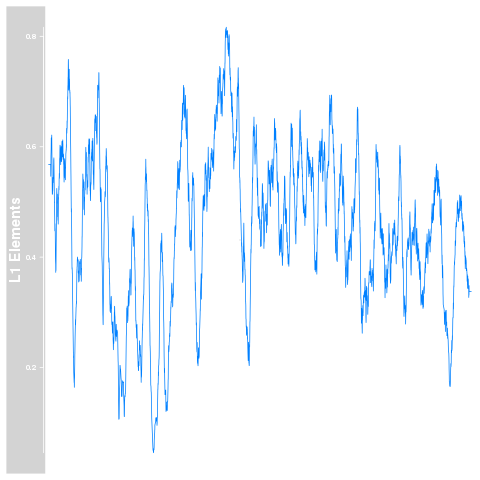

In [61]:
%%R

plotTracks(lineTrack, from=63000000, to=93000000)

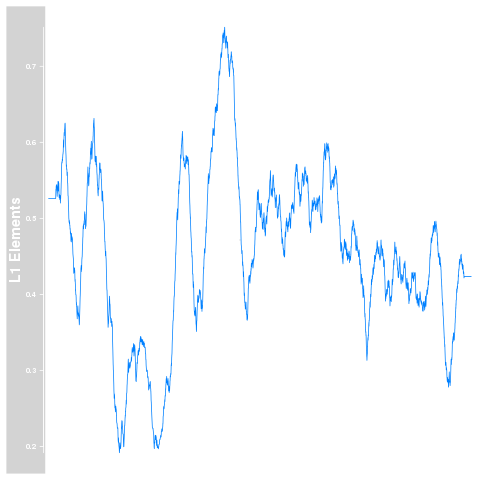

In [250]:
%%R

plotTracks(lineTrack, from=63000000, to=93000000)

In [60]:
lmm_features = lmm_features.merge(gene_info[['chrom', 'start', 'end']], 
                                  left_on='gene_id', right_index=True)
lmm_features.columns = [c.replace('chrom', 'chromosome') for c in lmm_features.columns]

In [66]:
t = x_all.ix[:, :, 'major_allele_freq']
r = gene_info.ix[t.index, ['start', 'end']]

In [67]:
%%R -i t,r

mafTrack <- DataTrack(range=r, data=t, genome="hg19", type=c("smooth", "p"), alpha=0.75, lwd=8,
                      span=0.05,
                      chromosome="chrX", name="Major Allele Frequency")

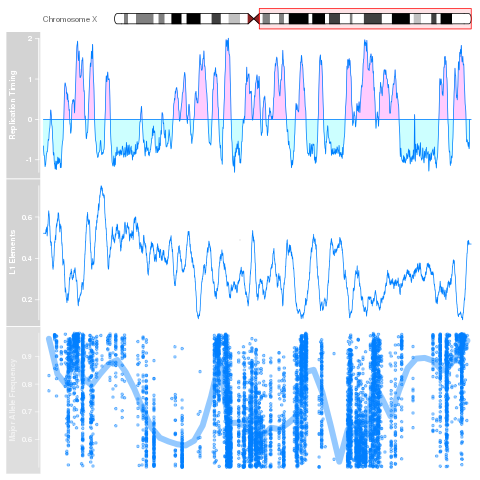

In [70]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=63000000, to=155270560)

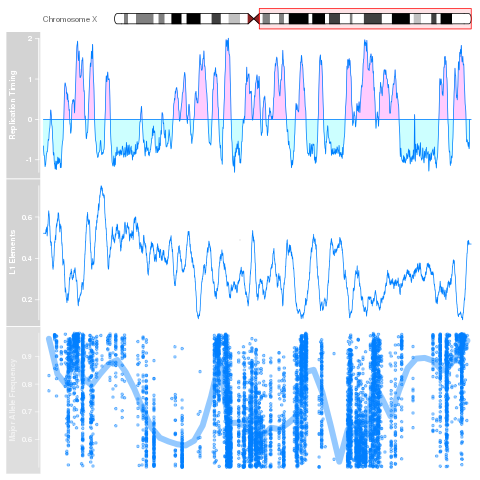

In [75]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=63000000, to=155270560)

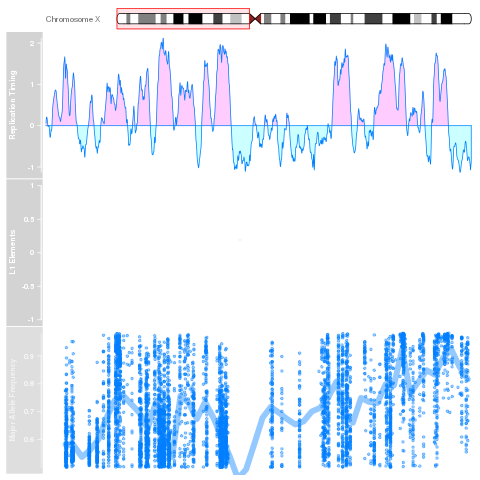

In [76]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=0, to=58100000)

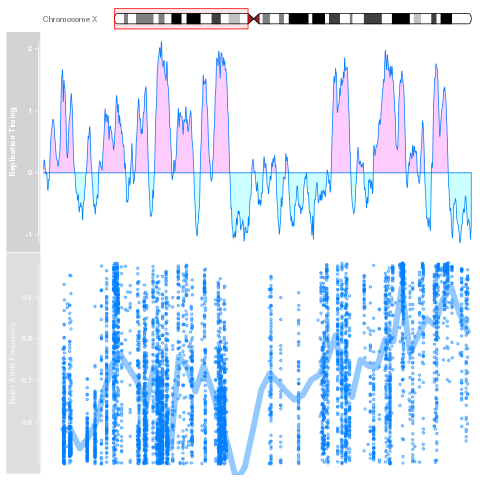

In [226]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=0, to=58100000)

In [ ]:
%%R -i rt_bedgraph,sig_bedgraph,mean_freq_z_bedgraph,line_one_bam

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX")
# sig <- system.file(sig_bedgraph, package = "Gviz")
sigTrack <- DataTrack(range=sig_bedgraph, genome="hg19", type=c("smooth", "p"),
                      chromosome="chrX", name="Percent Significant ASE")
# mfz <- system.file(sig_bedgraph, package = "Gviz")
mfzTrack <- DataTrack(range=mean_freq_z_bedgraph, genome="hg19", type=c("smooth", "p"),
                      chromosome="chrX", name="Mean Frequency z Score")
#rt <- system.file(rt_bedgraph, package = "Gviz")
rtTrack <- DataTrack(range=rt_bedgraph, genome="hg19", type="l",
                     chromosome="chrX", name="Replication Timing")
lineTrack <- DataTrack(range=line_one_bam, genome="hg19", type="l", window=-1,
                       chromosome="chrX", name="L1 Elements")

## Reactivation QTLs

In [28]:
g = set(gene_info[gene_info.chrom == 'chrX'].index) & set(ase_pval.index)
s = meta[(meta.sex == 'F') & (meta.in_eqtl)].index
fx_maj_af = maj_af.ix[g, s]
fx_maj_af_f = fx_maj_af[(fx_maj_af.isnull() == False).sum(axis=1) >= 40]

In [29]:
cpy.makedir(os.path.join(outdir, 'inact_eqtl'))
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'gene_to_regions.p')
gene_to_regions = cPickle.load(open(fn, 'rb'))

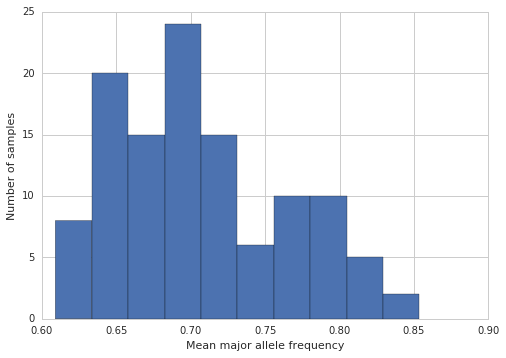

In [30]:
fx_maj_af_f.mean().hist()
plt.ylabel('Number of samples')
plt.xlabel('Mean major allele frequency');

I'm going to substract the mean from each sample (column) to account for 
differences in overall reactivation.

In [31]:
fx_maj_af_f = fx_maj_af_f - fx_maj_af_f.mean()

In [32]:
def run_emmax_sge(gene_id, mem=4):
    """Run EMMAX for X inactivation eQTL."""
    se = fx_maj_af_f.ix[gene_id].dropna()
    se = cpb.general.transform_standard_normal(se)
    wgs = cpy.get_best_wgs_sample(meta.ix[se.index, 'subject_id'])
    se.index = wgs.wgs_id
    se = se[sorted(se.index)]
    
    toutdir = os.path.join(outdir, 'inact_qtl', gene_id)
    cpy.makedir(toutdir)
    
    samples = os.path.join(toutdir, 'emmax_samples.tsv')
    with open(samples, 'w') as f:
        f.write('\n'.join(se.index) + '\n')
    
    exp = os.path.join(toutdir, 'maj_af_std_norm.tsv')
    pd.DataFrame(se, columns=[gene_id]).T.to_csv(exp, sep='\t')
    
    vcf = '/projects/CARDIPS/pipeline/WGS/mergedVCF/CARDIPS_201512.femaleX.PASS.vcf.gz'
    regions = ','.join([x[3:] for x in gene_to_regions[gene_id]])
    kin = os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin')

    res = datetime.datetime.now()
    date = re.sub(r'\D', '_', str(res))
    fn = os.path.join(toutdir, '{}_{}.sh'.format(gene_id, date))
    with open(fn, 'w') as f:
        f.write('#!/bin/bash\n\n')
        f.write('#$ -N emmax_{}_{}_x\n'.format(gene_id, date))
        num_threads = 4
        f.write('#$ -l short\n')
        f.write('#$ -l h_vmem={}G\n'.format(mem / num_threads))
        f.write('#$ -pe smp {}\n'.format(num_threads))
        f.write('#$ -S /bin/bash\n')
        f.write('#$ -o {}/emmax_{}_{}_x.out\n'.format(toutdir, gene_id, date))
        f.write('#$ -e {}/emmax_{}_{}_x.err\n\n'.format(toutdir, gene_id, date))
        f.write('module load cardips/1\n')
        f.write('source activate cie\n\n')
        
        cpy.makedir(toutdir)
        c = 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                vcf,
                regions,
                exp,
                samples,
                kin,
                toutdir,
            ])
        f.write(c + '\n\n')
    subprocess.check_call('qsub {}'.format(fn), shell=True)

In [33]:
if not os.path.exists(os.path.join(outdir, 'inact_qtl')):
    for g in fx_maj_af_f.index:
        run_emmax_sge(g)

In [34]:
dys = glob.glob(os.path.join(outdir, 'inact_qtl', '*'))
gene_ids = []
pvalues = []
for dy in dys:
    gene_id = os.path.split(dy)[1]
    res_fn = os.path.join(os.path.join(dy, '{}.tsv'.format(gene_id)))
    res = ciepy.read_emmax_output(res_fn)
    min_fn = os.path.join(os.path.join(dy, 'minimum_pvalues.tsv'))
    min_pvals = pd.read_table(min_fn, header=None, squeeze=True)
    pvalues.append((1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1))
    gene_ids.append(gene_id)
pvalues = pd.Series(pvalues, index=gene_ids)

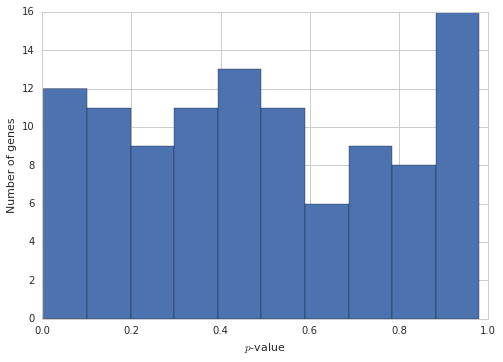

In [35]:
pvalues.hist()
plt.xlabel('$p$-value')
plt.ylabel('Number of genes');

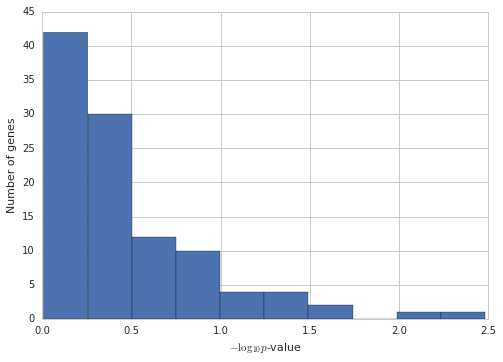

In [36]:
(-np.log10(pvalues)).hist()
plt.xlabel('$-\log_{10} p$-value')
plt.ylabel('Number of genes');

In [37]:
r = sms.sandbox.stats.multicomp.multipletests(pvalues, method='fdr_bh')
pvalues_bh = pd.Series(r[1], index=pvalues.index)
sum(pvalues_bh < 0.05)

0